In [1]:
import numpy as np
from matplotlib import pyplot as plt

import loki
from loki.libloki.configs import PulsarSearchConfig
from loki.libloki.ffa import FFAPlan
from loki.libloki.prune import PruningManager
from pyloki.config import ParamLimits
from pyloki.core.taylor import generate_branching_pattern
from pyloki.detection import thresholding
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import PruningStatsPlotter, ScatteredPeriodogram
from pyloki.prune import prune_dyp_tree
from pyloki.simulation.pulse import PulseSignalConfig

tobs = 2147.483648


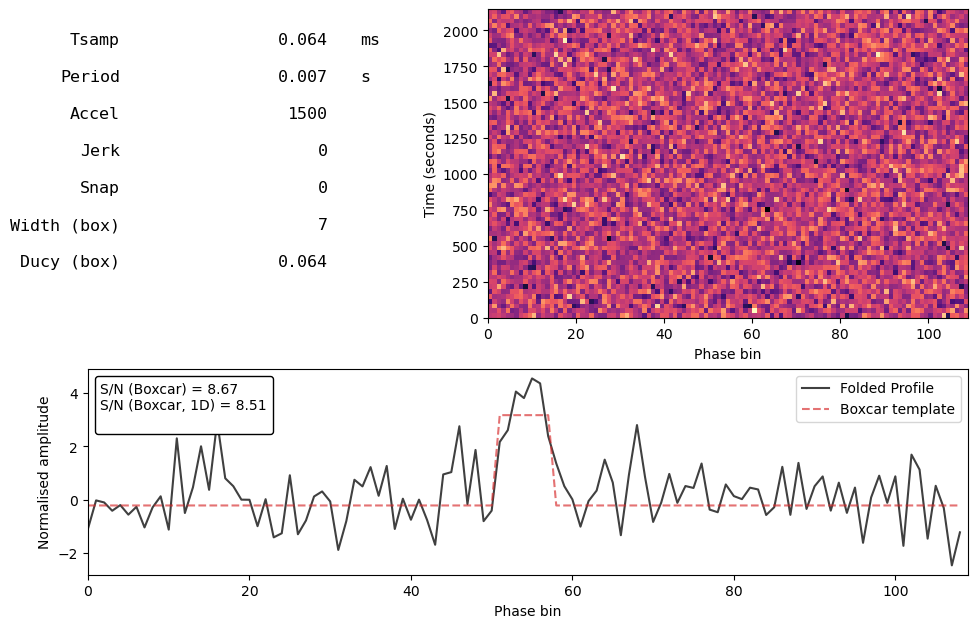

In [2]:
pulsar_period = 0.007
dt = 64e-6
accel = 1500         
nsamps = 2**25
mod_kwargs = {"acc": accel}
cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=8.5, ducy=0.1, mod_kwargs=mod_kwargs)
print(f"tobs = {cfg.tobs}")
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs)
plt.show()

In [3]:
tol_bins = 1 
fold_bins = 64
p = ParamLimits.from_taylor((140.0, 145.0), (-2500.0, 2500.0) )
print(f"Param limits: {p.limits}")
bseg_brute = cfg.nsamps // 16384
bseg_ffa = cfg.nsamps // 128
search_cfg = PulsarSearchConfig(nsamps=cfg.nsamps, tsamp=cfg.dt, nbins=fold_bins, tol_bins=tol_bins, param_limits=p.limits,
                                bseg_brute=bseg_brute, bseg_ffa=bseg_ffa, prune_poly_order=2, nthreads=8, ducy_max=0.2, wtsp=1.1,
                                use_fft_shifts=True)
plan = FFAPlan(search_cfg)
branching_pattern = plan.generate_branching_pattern()
branching_pattern

Param limits: [(-2500.0, 2500.0), (140.0, 145.0)]


array([8.        , 3.        , 2.        , 3.        , 1.        ,
       1.        , 2.        , 3.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 2.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 3.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       2.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 2.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

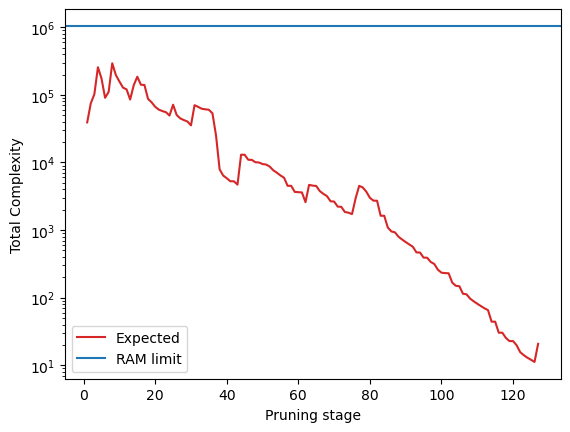

In [4]:
thresholds = np.array([2.1, 2.5, 2.6, 2.5, 2.7, 3. , 3.1, 2.9, 3.1, 3.1, 3.1, 2.9, 3.2,
       3.5, 3.6, 3.6, 3.2, 3.7, 3.6, 3.6, 3.5, 3.4, 3.3, 3.4, 3.9, 4. ,
       3.9, 3.8, 3.7, 3.8, 3.5, 3.6, 3.6, 3.5, 3.4, 3.6, 4.1, 4.5, 4.5,
       4.4, 4.4, 4. , 4.3, 4.3, 4. , 4.3, 4. , 4.2, 4. , 4.1, 4. , 4.1,
       4.2, 4.2, 4.2, 4.2, 4.4, 4. , 4.4, 4.2, 4.1, 4.5, 4.5, 4.4, 4.3,
       4.5, 4.5, 4.5, 4.6, 4.4, 4.6, 4.4, 4.6, 4.5, 4.5, 4.6, 4.4, 4.5,
       4.6, 4.7, 4.7, 4.4, 4.9, 4.5, 5. , 5. , 4.9, 5. , 5. , 5. , 5. ,
       5. , 5.1, 4.9, 5.1, 4.9, 5.1, 5.1, 5.2, 5.2, 5.1, 5. , 5.3, 5.3,
       5.2, 5.4, 5.3, 5.4, 5.4, 5.4, 5.4, 5.4, 5.4, 5.6, 5.3, 5.7, 5.3,
       5.7, 5.7, 5.3, 5.7, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8])
thresh_state = thresholding.evaluate_scheme(thresholds, branching_pattern, ref_ducy=0.1, nbins=64,
                                            ntrials=1024, snr_final=8.5, ducy_max=0.2, wtsp=1.5)
x = np.arange(1, len(branching_pattern) + 1)
nparam_vol = plan.ncoords[-1]
plt.semilogy(x, np.array(thresh_state.get_info("complexity")) * nparam_vol, label="Expected", c="tab:red")
plt.axhline(2**20, label="RAM limit", c="tab:blue")
plt.xlabel("Pruning stage")
plt.ylabel("Total Complexity")
plt.legend()
plt.show()

In [5]:
prn_manager = PruningManager(search_cfg, thresholds, n_runs=32, max_sugg=2**20, batch_size=1024)
prn_manager.execute(tim_data.ts_e, tim_data.ts_v, outdir="pruning_results/accel_test/", file_prefix="test_accel", kind="taylor", show_progress=False)

[2025-08-20 17:30:08.712] [info] PruningManager: Initializing with FFA
[2025-08-20 17:30:08.745] [info] FFACOMPLEX Memory Usage: 0.34 GB (1 buffers) + 0.00 GB (coords)
[2025-08-20 17:30:08.774] [info] FFACOMPLEX::execute started
[2025-08-20 17:30:08.774] [info] FFACOMPLEX::initialize started
[2025-08-20 17:30:09.748] [info] FFACOMPLEX::initialize took 973 ms
[2025-08-20 17:30:09.785] [info] FFACOMPLEX::execute took 1010 ms
[2025-08-20 17:30:09.791] [info] Starting Pruning for 32 runs, with 8 threads
[2025-08-20 17:30:10.533] [info] Pruning run 020: Memory Usage: 0.58 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 17:30:10.533] [info] Pruning run 020: initialized
[2025-08-20 17:30:10.607] [info] Pruning run 000: Memory Usage: 0.58 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 17:30:10.608] [info] Pruning run 000: initialized
[2025-08-20 17:30:10.613] [info] Pruning run 025: Memory Usage: 0.58 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 17:30:10.613] [info] Pruning run 02

In [6]:
result_file = "pruning_results/accel_test/test_accel_pruning_nstages_128_results.h5"
pgram = ScatteredPeriodogram.load(result_file)
print(f"True params, a: {cfg.mod_kwargs["acc"]:.3f}, f: {cfg.freq:.10f}")
print(pgram.get_summary_cands(10, run_id=None))

True params, a: 1500.000, f: 142.8571428571
Top candidates:
dparams: daccel: 0.2099153238, dfreq: 1.455191523e-05
Run: 037_10, S/N: 8.10, accel: 1496.56, freq: 142.857114
Run: 037_10, S/N: 7.94, accel: 1496.56, freq: 142.857129
Run: 037_10, S/N: 7.47, accel: 1496.56, freq: 142.857143
Run: 037_10, S/N: 7.32, accel: 1496.56, freq: 142.857158
Run: 102_26, S/N: 6.95, accel: 65.21, freq: 142.912745
Run: 090_23, S/N: 6.92, accel: 1327.58, freq: 143.986772
Run: 090_23, S/N: 6.90, accel: 1327.58, freq: 143.986757
Run: 102_26, S/N: 6.89, accel: 65.21, freq: 142.912760
Run: 016_05, S/N: 6.89, accel: -409.41, freq: 144.181701
Run: 127_32, S/N: 6.88, accel: 1073.37, freq: 141.889350


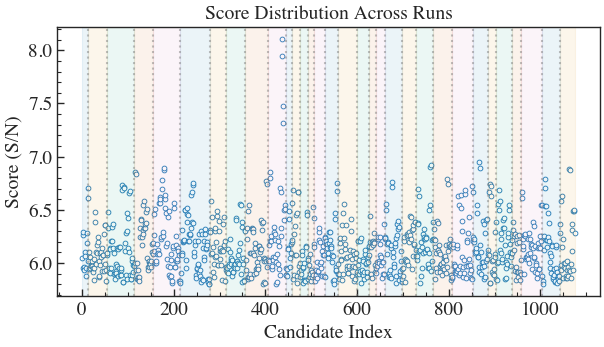

In [7]:
pgram.plot_scores(kind="scatter", run_id=None)
plt.show()

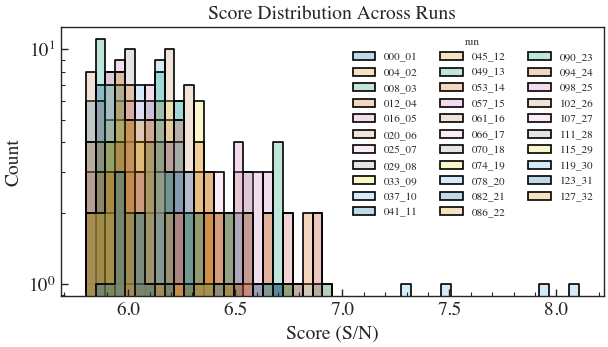

In [8]:
pgram.plot_scores(kind="hist", run_id=None)
plt.show()

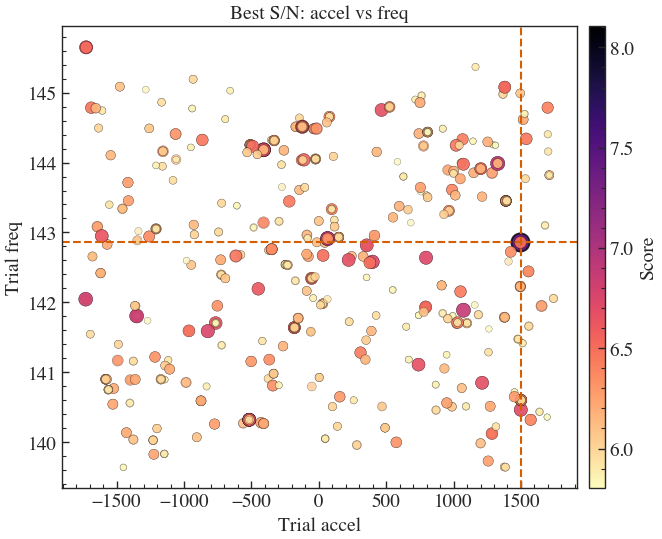

In [9]:
pgram.plot_correlation("accel", "freq", true_values={"accel": cfg.mod_kwargs["acc"], "freq": cfg.freq}, run_id=None)
plt.show()

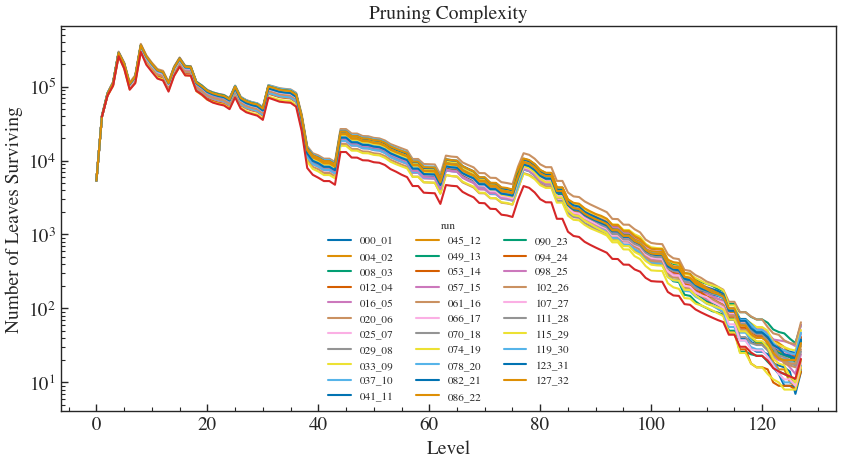

In [10]:
pstats = PruningStatsPlotter.load(result_file)
fig = pstats.plot_level_stats(run_id=None)
x = np.arange(1, len(branching_pattern) + 1)
ax_list = fig.axes
ax_list[0].plot(x, np.array(thresh_state.get_info("complexity")) * nparam_vol, label="Expected", c="tab:red")
plt.show()